_All data was collected on 05 October 2024._

In [2]:
import hashlib
import logging
import os
import shutil
import sqlite3
import time
import random
import re
import requests
from collections import defaultdict

import networkx as nx
import praw
import pandas as pd
from selenium import webdriver #also need a standalone chromedriver executable
from tqdm.notebook import tqdm, trange
from dotenv import load_dotenv
from matplotlib_venn import venn2
from pprint import pprint

In [3]:
logging.basicConfig(level=logging.INFO)
load_dotenv(); #loading environmental variables from .env

In [4]:
def notify(title, message):
    #Send a Telegram message using noti
    #https://github.com/variadico/noti
    if shutil.which("noti"):
        os.system("noti -g -t '%s' -m '%s'" % (title, message))

# Getting list of subreddits

## Getting top 25'000 subreddits from www.reddit.com/best/communities/1/

In [18]:
base_url = "https://www.reddit.com/best/communities/%i/"
regex = re.compile(r'data-prefixed-name="r/([^\"]*)"') #regex found by inspecting the source code
best_subs = []

for i in tqdm(range(1, 101)):
    res = requests.get(base_url % i)
    subs = regex.findall(res.text)
    if len(subs) < 250:
        print(f"Found fewer subs than expected ({len(subs)} < 250) at {base_url % i}")
    best_subs += subs
    time.sleep(0.1)

print(f"Compiled best-communities.txt ({len(best_subs)} subs)")
notify("reddit-mods-ds", f"Compiled best-communities.txt ({len(best_subs)} subs)")

  0%|          | 0/100 [00:00<?, ?it/s]

Found fewer subs (249) than expected at https://www.reddit.com/best/communities/97/
Found fewer subs (249) than expected at https://www.reddit.com/best/communities/98/


In [19]:
with open('best-subreddits.txt', 'w') as f:
    f.write('\n'.join(best_subs) + '\n')

In [20]:
len(best_subs)

24998

Two pages listed 249 subs, as opposed to 250, probably because two missing communities turned private or were quarantined since they got listed. Therefore, I only collected 24'998 subs in total.

##  Getting most popular subreddits from www.reddit.com/subreddits/

Note than some of Reddit's most popular communities are [missing](https://www.reddit.com/r/ModSupport/comments/xu57y6/our_subreddit_is_not_showing_in_the_best_reddit/) from www.reddit.com/best/communities/1/. That's probably because Reddit doesn't want to suggest NSFW or controversial communities to new users or advertisers. Some examples of missing subs:
* `r/iamatotalpieceofshit`
* `r/therewasanattempt`
* `r/illusions`
* `r/Palestine`
* `r/PublicFreakout`
* `r/CombatFootage`
* `r/FUCKYOUINPARTICULAR`
* `r/IsItBullshit`
* `r/IdiotsFightingThings`
* `r/JordanPeterson`
* `r/MensRights`
* `r/OneSecondBeforeDisast`
* `r/TIHI`
* `r/ThatsInsane`
* `r/TrueUnpopularOpinion`
* `r/Wellthatsucks`
* `r/Whatcouldgowrong`
* `r/cringe`
* `r/sex`
* `r/stupidquestions`

To overcome the issue, I also scraped all the most popular communities listed at www.reddit.com/subreddits/. There was a total of 4430 of them.

In [ ]:
#Old Reddit blocks non-browser requests, so I've got to use Selenium

with open("popular-subreddits.txt", "w") as out:
    n_popular_subs = 0
    url = "https://www.reddit.com/subreddits"
    regex_subs = re.compile(r'class="titlerow"><a href="https://www.reddit.com/r/([^"]+)/"')
    regex_next = re.compile(r'<span class="next-button">\s*<a href="([^"]*)')
    driver = webdriver.Chrome()

    while True:
        attempts = 0
        matches = None
        while not matches and attempts < 5:
            driver.get(url)
            source = driver.page_source
            next_subs = regex_subs.findall(source)
            out.write('\n'.join(next_subs) + '\n')
            n_popular_subs += len(next_subs)
            matches = regex_next.findall(source)
            time.sleep(5 + 5 * attempts)
            attempts += 1

        print(f"Processed {url}, {len(next_subs)} subs")
        if not matches:
            break #reached end of list

        [url] = matches
        out.flush()
        time.sleep(5)

print(f"Compiled popular-communities.txt ({n_popular_subs} subs)")
notify("reddit-mods-ds", f"Compiled popular-communities.txt ({n_popular_subs} subs)")

In [42]:
print(n_popular_subs)

4430


## Pooling two lists together 

In [27]:
with open("popular-subreddits.txt", "r") as f:
    popular_subs = [s.strip() for s in f.readlines()]
    
with open("best-subreddits.txt", "r") as f:
    best_subs = [s.strip() for s in f.readlines()]

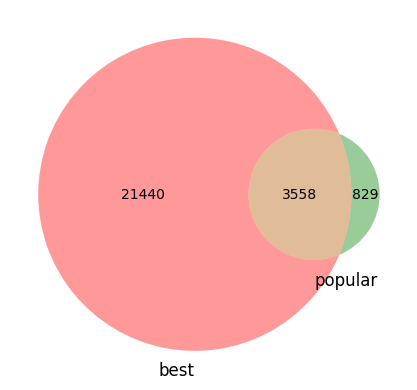

In [28]:
venn2([set(best_subs), set(popular_subs)], set_labels=('best', 'popular'));

In [35]:
#first writing popular subs, then top subs
with open("all-top-subreddits.txt", 'w') as f:
    for s in popular_subs:
        if len(s) > 0:
            f.write(s + '\n')
    popular_set = set(popular_subs)
    for s in best_subs:
        if len(s) > 0 and s not in popular_set:
            f.write(s + '\n')

In [36]:
!wc -l all-subreddits.txt

   25871 all-subreddits.txt


I will be inspecting 25'871 subs in total.

## Comparing February 2024 with October 2024

This is the second iteration of this dataset. The first one was collected in February 2024. Let's compare the two to say if the lists of popular/best subreddits changed significantly.

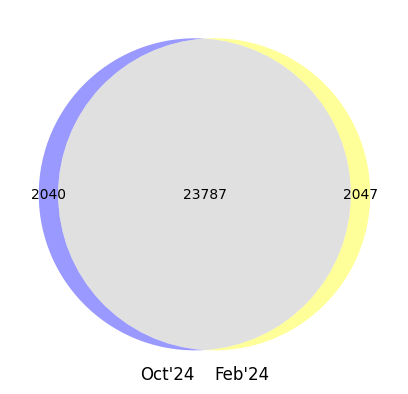

In [73]:
with open("all-top-subreddits.txt", 'r') as f:
    all_subs_oct = set([s.strip() for s in f.readlines()])
    
feb_rawlink = "https://raw.githubusercontent.com/almayor/reddit-mods-dataset/e95f99741a37e1ac8da1b8a3b01ada7983cc59f1/code/all-subreddits.txt" 
r = requests.get(feb_rawlink)
all_subs_feb = set(r.text.split())

venn2([all_subs_oct, all_subs_feb], set_labels=("Oct'24", "Feb'24"), set_colors=("blue", "yellow"));

Let's examine some of the new subs:

In [99]:
print("New best/popular subs since February 2024:", end='\n • ')
print(*random.choices(list(all_subs_oct.difference(all_subs_feb)), k=15), sep='\n • ')

New best/popular subs since February 2024:
 • ApplyingIvyLeague
 • SugarBABYonlyforum
 • Uniteagainsttheright
 • adjusters
 • khajiithaswares
 • CestCaLaFrance
 • onlinejobsforall
 • CatsWithKittens
 • khajiithaswares
 • 3BodyProblemTVShow
 • MotivationalQuotes
 • SolCoins
 • blackops6
 • DIYCosmeticProcedures
 • Archiveofourownmemes


In [97]:
print("Subs that are no longer best/popular:", end='\n • ')
print(*random.choices(list(all_subs_feb.difference(all_subs_oct)), k=15), sep='\n • ')

Subs that are no longer best/popular:
 • Teenager
 • Brawlmaps
 • AbandonedThemeParks
 • TamilNadu
 • amithejerkpodcast
 • Jobs_OG
 • glutenfreememes
 • lgg6
 • pixelpumpers
 • StreetwearSales
 • landconservation
 • Treasure
 • MCBourbonnais
 • State_of_Survival
 • MostFamousLatinas


# Inspecting subreddits

To increase speed, I will be using two different Reddit accounts. I have authorized a `script` application for each of them on www.reddit.com/prefs/apps.

I will be using the schema
![](schema.png)

In [5]:
class DBFactory:

    db = None

    def __call__(self):
        DBFactory.db = DBFactory.db or sqlite3.connect('db.sqlite3')
        self.create_tables()
        self.init_tables()
        return self.db

    
    def create_tables(self):
        cursor = self.db.cursor()
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS subs(
                name TEXT PRIMARY KEY,
                nsubscr INTEGER,
                processed BOOLEAN DEFAULT 0
            )
        ''')
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS mods(
                mod TEXT,
                sub TEXT,
                PRIMARY KEY (mod, sub)
            )
        ''')
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS users(
                name TEXT PRIMARY KEY,
                is_bot BOOLEAN,
                last_active INTEGER,
                processed BOOLEAN DEFAULT 0
            )
        ''')
        self.db.commit()
        cursor.close()

    def init_tables(self):
        cursor = self.db.cursor()
        self.db.commit()
        cursor.close()
        

In [9]:
class SubInspector:
    
    def __init__(self, reddit):
        self.reddit = reddit
        self.db = DBFactory()()
        self.cursor = self.db.cursor()

    
    def inspect(self, *, sub_name=None):        
        self.cursor.execute("SELECT name FROM subs WHERE name=? AND processed=1", (sub_name,))
        if self.cursor.fetchone():
            return 0 #sub already processed
            
        sub = self.reddit.subreddit(sub_name)
        self.cursor.execute("INSERT OR IGNORE INTO subs(name, nsubscr) VALUES(?,?)", (sub.display_name, sub.subscribers))
        for mod in sub.moderator():
            self.cursor.execute("INSERT OR IGNORE INTO mods(mod, sub) VALUES(?,?)", (mod.name, sub.display_name))
            self.cursor.execute("INSERT OR IGNORE INTO users(name) VALUES(?)", (mod.name,))

        self.cursor.execute("UPDATE subs SET processed = 1 WHERE name = ?", (sub.display_name,))
        self.db.commit()

        logging.info(f'Inspected sub {sub.display_name}')
        return 1 #sub is new


    def set_reddit(self, reddit):
        self.reddit = reddit

    
    def __del__(self):
        self.cursor.close()
            

In [7]:
reddit1 = praw.Reddit(
    client_id=os.getenv("CLIENT_ID_1"),
    client_secret=os.getenv("CLIENT_SECRET_1"),
    user_agent=os.getenv("USER_AGENT_1"),
    username=os.getenv("USER_NAME_1"),
    password=os.getenv("USER_PASS_1")
)

reddit2 = praw.Reddit(
    client_id=os.getenv("CLIENT_ID_2"),
    client_secret=os.getenv("CLIENT_SECRET_2"),
    user_agent=os.getenv("USER_AGENT_2"),
    username=os.getenv("USER_NAME_2"),
    password=os.getenv("USER_PASS_2")
)

In [ ]:
with open('all-top-subreddits.txt', 'r') as f:
    all_subs = [s.strip() for s in f.readlines()]

inspector = SubInspector(reddit1)
npr = 0

for i, sub_name in enumerate(tqdm(all_subs)):    
    if inspector.inspect(sub_name=sub_name):
        npr += 1
        time.sleep(0.5)

    #magic to overcome Reddit's ratelimits
    if npr and npr % 25 == 0:
        inspector.set_reddit(reddit2 if inspector.reddit is reddit1 else reddit1)
    if npr and npr % 50 == 0:
        time.sleep(10)
    if npr and npr % 100 == 0:
        notify("reddit-mod-db", f"Processed {npr} subs, {len(all_subs) - i} left...") 
    if npr and npr % 500 == 0:
        time.sleep(10)
    if npr and npr % 1000 == 0:
        time.sleep(10)

notify("reddit-mod-db", f"Done processing top {len(all_subs)} subs!") 

  0%|          | 0/25870 [00:00<?, ?it/s]

INFO:root:Inspected sub Home
INFO:root:Inspected sub AskReddit
INFO:root:Inspected sub NoStupidQuestions
INFO:root:Inspected sub BaldursGate3
INFO:root:Inspected sub facepalm
INFO:root:Inspected sub interestingasfuck
INFO:root:Inspected sub Damnthatsinteresting
INFO:root:Inspected sub LivestreamFail
INFO:root:Inspected sub pics
INFO:root:Inspected sub Palworld
INFO:root:Inspected sub AmItheAsshole
INFO:root:Inspected sub mildlyinfuriating
INFO:root:Inspected sub Piracy
INFO:root:Inspected sub PeterExplainsTheJoke
INFO:root:Inspected sub funny
INFO:root:Inspected sub AITAH
INFO:root:Inspected sub movies
INFO:root:Inspected sub Helldivers
INFO:root:Inspected sub gaming
INFO:root:Inspected sub worldnews
INFO:root:Inspected sub leagueoflegends
INFO:root:Inspected sub pcmasterrace
INFO:root:Inspected sub Unexpected
INFO:root:Inspected sub news
INFO:root:Inspected sub politics
INFO:root:Inspected sub wallstreetbets
INFO:root:Inspected sub todayilearned
INFO:root:Inspected sub nottheonion
INF

In [ ]:
notify("reddit-mod-db", "Stopped!")

# Writing output 

## Pooling data

In [29]:
db = DBFactory()()
cursor = db.cursor()

In [44]:
with open('../subreddits.csv', 'w') as f:
    f.write('name,n_members\n')
    cursor.execute("""
        SELECT name, nsubscr FROM subs ORDER BY nsubscr DESC;
    """)
    for name, n_members in tqdm(cursor.fetchall()):
        f.write(f'{name},{n_members}\n')

  0%|          | 0/25834 [00:00<?, ?it/s]

In [47]:
with open('../moderators.csv', 'w') as f:
    f.write(',moderator,subreddit\n')
    cursor.execute("""
        SELECT mods.mod, mods.sub FROM mods LEFT JOIN subs ON mods.sub = subs.name ORDER BY subs.nsubscr DESC;
    """)
    for i, (moderator, subreddit) in enumerate(tqdm(cursor.fetchall()), 1):
        f.write(f'{i},{moderator},{subreddit}\n')

  0%|          | 0/125812 [00:00<?, ?it/s]

In [69]:
with open('../bots.csv', 'w') as f:
    f.write('name\n')
    cursor.execute("""
        SELECT name FROM bots;
    """)
    for (name, ) in cursor.fetchall():
        f.write(name + '\n')

## Anonymising personal data

Usernames are personal data, and can potentially be used to identify the individual. We will encode all moderator usernames by hashing them with SHA256.

In [2]:
df_mods = pd.read_csv('../moderators.csv', index_col=0)

In [10]:
sha256_enc = lambda x: hashlib.sha256(x.encode()).hexdigest()
df_mods['moderator'] = df_mods['moderator'].apply(sha256_enc)                         

In [11]:
df_mods.head()

,moderator,subreddit
1,1039a46c82d342ef6c1d1b77cc7175a4cabd8cfb3f2e8d...,announcements
2,f58a99ef5e6677314d0fb1e5e7a0ee7ed8aad22cdf93a3...,announcements
3,c750264db0d83c6a5d722207514ab117a3fce88d9e5a34...,announcements
4,a39672e330f0293d47e69ea37cf54ece0edf739892ed59...,announcements
5,8e1519f03793fb5db6129addf6ef138056d15791508344...,announcements


In [13]:
df_mods.to_csv('../moderators.csv')

## Writing graph 

In [14]:
df_subs = pd.read_csv('../subreddits.csv')
df_mods = pd.read_csv('../moderators.csv', index_col=0)

Writing as a bipartite graph, where both mods and subs are nodes.

In [15]:
n_members_dict = df_subs.set_index('name').to_dict()['n_members']

In [16]:
g = nx.Graph()
g.add_nodes_from(df_mods['moderator'].unique(), bipartite=0)
for sub in df_mods['subreddit'].unique():
    g.add_node(sub, size=n_members_dict[sub], bipartite=1)

g.add_edges_from([tuple(row) for row in df_mods[['moderator', 'subreddit']].values])
nx.write_gexf(g, '../graph.gexf')